In [1]:
from model_staging import create_cnn2D, fetch_images_dataframe
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

train_path = "C://Users//Alec//MyPython//Beatles/train_melspec"
test_path = "C://Users//Alec//MyPython//Beatles/test_melspec"

In [3]:
best_model_adam = keras.models.load_model("models/melspec/skopt_best_adamV3.h5")

In [4]:
test_gen = fetch_images_dataframe(test_df, x_col="song", 
                                  y_col="artist", 
                                  directory=test_path,
                                  batch_size=16, 
                                  target_size=(256, 256), 
                                  class_mode="categorical", 
                                  shuffle=False, seed=1, 
                                  save_format="png")

Found 216 validated image filenames belonging to 1 classes.


In [5]:
probabilities = best_model_adam.predict_generator(test_gen)

In [6]:
preds = np.argmax(probabilities, axis=1)

In [7]:
train_gen, valid_gen = fetch_images_dataframe(train_df, 
                                              x_col="song", 
                                              y_col="artist", 
                                              directory=train_path,
                                              batch_size=16, 
                                              target_size=(256, 256), 
                                              class_mode="categorical", 
                                              shuffle=True, seed=1, 
                                              validation_split=0.2, 
                                              save_format="png")
class_map = train_gen.class_indices

Found 601 validated image filenames belonging to 4 classes.
Found 150 validated image filenames belonging to 4 classes.


In [8]:
pred_df = pd.DataFrame(data={"songs": test_gen.filenames,
                                   "predictions": preds})

In [9]:
mapping = {v:k for k,v in class_map.items()}

In [10]:
pred_df["predictions"] = pred_df["predictions"].map(mapping)

In [11]:
pred_df.head(15)

,songs,predictions
0,Rock And Roll Music (Remastered 2009)-IRF6nmqc...,starr
1,Good Morning Good Morning (Remastered 2009)-sj...,mccartney
2,You Never Give Me Your Money (2019 Mix)-W8uZje...,mccartney
3,Being For The Benefit Of Mr. Kite! (Remastered...,mccartney
4,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png,mccartney
5,Carry That Weight (2019 Mix)-0RagyYjgY4g.png,Lennon
6,Dig A Pony (Remastered 2009)-LpdJE7HG8Ls.png,Lennon
7,Baby It's You (Remastered 2009)-AWUTlM6hz0g.png,Lennon
8,I'll Be Back (Remastered 2009)-fJSTBNTac6k.png,Lennon
9,Don't Bother Me (Remastered 2009)-k03IQbaTcxc.png,starr


In [12]:
pred_df.groupby("predictions").count()

,songs
predictions,
Lennon,28
harrison,21
mccartney,120
starr,47


In [13]:
pred_df = pred_df.merge(test_df[["album", "song"]], left_on="songs",right_on="song")
pred_df.drop("song", axis=1, inplace=True)

In [14]:
pred_df = pred_df.join(pd.DataFrame(probabilities))
pred_df.rename(mapping, axis=1, inplace=True)
pred_df[['Lennon', 'harrison', 'mccartney', 'starr']] = pred_df[['Lennon', 'harrison', 'mccartney', 'starr']].round(4)

In [15]:
pred_df.head(10)

,songs,predictions,album,Lennon,harrison,mccartney,starr
0,Rock And Roll Music (Remastered 2009)-IRF6nmqc...,starr,BeatlesForSale,0.0000,0.0129,0.2690,0.7181
1,Good Morning Good Morning (Remastered 2009)-sj...,mccartney,SgtPepper,0.0000,0.0004,0.9901,0.0095
2,You Never Give Me Your Money (2019 Mix)-W8uZje...,mccartney,AbbeyRoad,0.0000,0.0000,1.0000,0.0000
3,Being For The Benefit Of Mr. Kite! (Remastered...,mccartney,SgtPepper,0.0001,0.4407,0.5591,0.0001
4,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png,mccartney,BeatlesForSale,0.0002,0.0516,0.5134,0.4348
5,Carry That Weight (2019 Mix)-0RagyYjgY4g.png,Lennon,AbbeyRoad,0.9999,0.0001,0.0000,0.0000
6,Dig A Pony (Remastered 2009)-LpdJE7HG8Ls.png,Lennon,LetItBe,0.9893,0.0000,0.0046,0.0061
7,Baby It's You (Remastered 2009)-AWUTlM6hz0g.png,Lennon,PleasePleaseMe,0.8281,0.1676,0.0042,0.0001
8,I'll Be Back (Remastered 2009)-fJSTBNTac6k.png,Lennon,HardDaysNight,0.9951,0.0001,0.0001,0.0047
9,Don't Bother Me (Remastered 2009)-k03IQbaTcxc.png,starr,WithTheBeatles,0.0014,0.3124,0.2682,0.4181


In [16]:
album_years = {
    'PleasePleaseMe' : 1963,
    'WithTheBeatles' : 1963,
    'HardDaysNight' : 1964,
    'BeatlesForSale' : 1964,
    'Help!' : 1965,
    'RubberSoul' : 1965,
    'Revolver' : 1966,
    'MagicalMysteryTour': 1967,
    'SgtPepper' : 1967,
    'WhiteAlbum' : 1968,
    'YellowSubmarine' : 1969,
    'AbbeyRoad': 1969,
    'LetItBe' : 1970
}

In [17]:
album_grp = pred_df.groupby(["album", "predictions"]).count()
album_grp.reset_index(inplace=True)
album_grp = album_grp.iloc[:, :3]
album_grp.head()

,album,predictions,songs
0,AbbeyRoad,Lennon,4
1,AbbeyRoad,harrison,2
2,AbbeyRoad,mccartney,28
3,AbbeyRoad,starr,6
4,BeatlesForSale,Lennon,1


In [18]:
album_grp['album_year'] = album_grp['album'].map(album_years)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

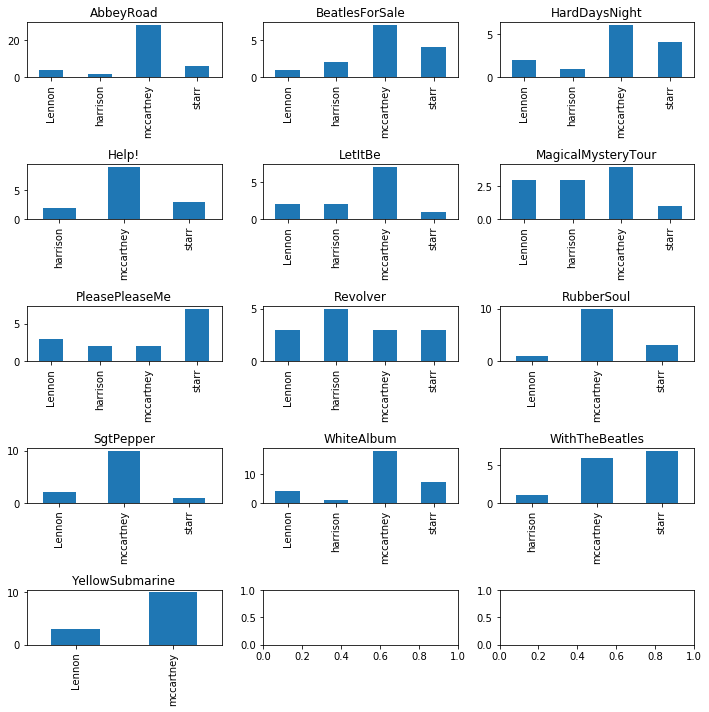

In [22]:
albums = album_grp["album"].unique()

fig, axes = plt.subplots(5, 3, figsize=(10,10))
axes = axes.flatten()
for i, alb in enumerate(albums):
    ax = axes[i]
    album_grp[album_grp["album"] == alb].plot(kind='bar', x='predictions', y='songs', ax=ax, legend=None)
    ax.set_xlabel(None)
    ax.set_title(alb)
    plt.tight_layout()
plt.savefig("results_by_album.png")

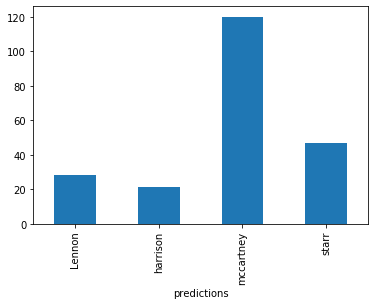

In [24]:
album_grp.groupby("predictions")["songs"].sum().plot(kind='bar')
plt.savefig("total_predictions.png")

In [25]:
album_grp.groupby("predictions")["songs"].sum()

predictions
Lennon        28
harrison      21
mccartney    120
starr         47
Name: songs, dtype: int64

In [26]:
train_df.groupby("artist").count()

,album,song
artist,,
Lennon,111,111
harrison,118,118
mccartney,293,293
starr,229,229


In [47]:
train_df.pivot_table(values='song', index='artist', aggfunc='count') / train_df.pivot_table(values='song', index='artist', aggfunc='count')['song'].sum()

,song
artist,
Lennon,0.147803
harrison,0.157124
mccartney,0.390146
starr,0.304927


In [33]:
album_grp.sort_values(["album_year", "album"])

,album,predictions,songs,album_year
23,PleasePleaseMe,Lennon,3,1963
24,PleasePleaseMe,harrison,2,1963
25,PleasePleaseMe,mccartney,2,1963
26,PleasePleaseMe,starr,7,1963
41,WithTheBeatles,harrison,1,1963
42,WithTheBeatles,mccartney,6,1963
43,WithTheBeatles,starr,7,1963
4,BeatlesForSale,Lennon,1,1964
5,BeatlesForSale,harrison,2,1964
6,BeatlesForSale,mccartney,7,1964


In [39]:
album_grp.groupby(["predictions", "album_year"])["songs"].sum()

predictions  album_year
Lennon       1963           3
             1964           3
             1965           1
             1966           3
             1967           5
             1968           4
             1969           7
             1970           2
harrison     1963           3
             1964           3
             1965           2
             1966           5
             1967           3
             1968           1
             1969           2
             1970           2
mccartney    1963           8
             1964          13
             1965          19
             1966           3
             1967          14
             1968          18
             1969          38
             1970           7
starr        1963          14
             1964           8
             1965           6
             1966           3
             1967           2
             1968           7
             1969           6
             1970           1
Name: songs, dty

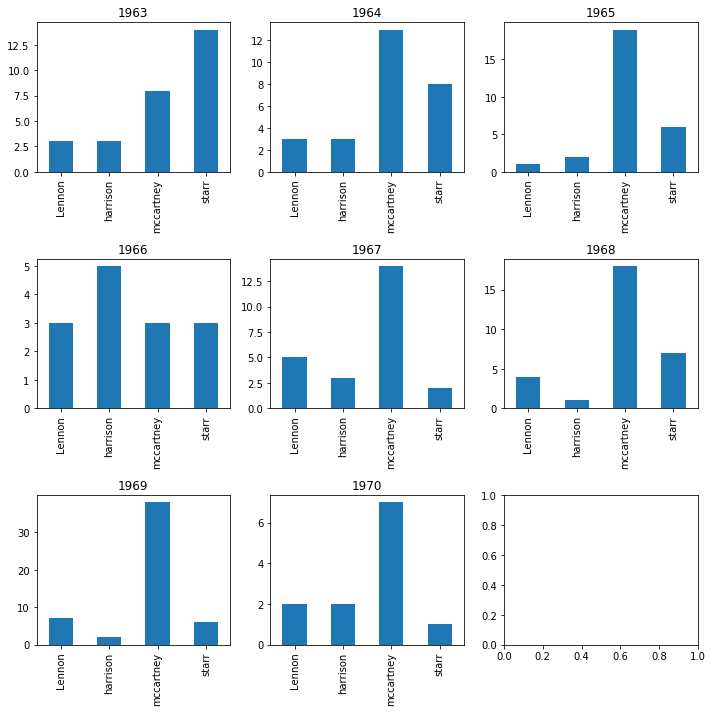

In [45]:
yrs = album_grp["album_year"].unique()
yrs.sort()
yr_grp = album_grp.groupby(["predictions", "album_year"])["songs"].sum().reset_index()
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()
for i, yr in enumerate(yrs):
    ax = axes[i]
    yr_grp[yr_grp["album_year"] == yr].plot(kind='bar', x='predictions', y='songs', ax=ax, legend=None)
    ax.set_xlabel(None)
    ax.set_title(yr)
    plt.tight_layout()
plt.savefig("results_by_year.png")